# Water flux within the root &mdash; Numerical solutions in DuMu${}^x$

_by Daniel Leitner, Andrea Schnepf, Timo Koch_

In the following we will give some hints how to solve Benchmark 1 & 2, using [DuMu${}^x$](www.dumux.org). The source code is available on [Github](https://github.com/Plant-Root-Soil-Interactions-Modelling/dumux-rosi.git).

## General remarks


In DuMu${}^x$ we base the problem on the one-phase porous medium model (`porousmediumflow/1p/model.hh`) meaning there is one fluid phase (water) inside a porous medium (root). Hence, the root is modeled as a porous medium, where the root xylem is the pore space filled with water and all other root components constitute the solid matrix.

Next we have to do some C++ programming specifying the exact benchmark scenario. This is done by calculating the permeability from our parameters (in the _spatial parameters_ class $\rightarrow$ `RootsParams` in `rootsparams.hh`), and by defining the boundary conditions and the source term (in the _problem_ class $\rightarrow$ `RootsProblem` in `rootsproblem.hh`).

In the spatial parameter class (`RootsParams`) we set the permeability by extending the class `FVSpatialParamsOneP` (finite volume spatial parameters for one-phase models) and overwriting the following member function

```C++
Scalar extrusionFactor(const Element& element,
                       const SubControlVolume& scv,
                       const ElementSolution& elemSol) const
{
    const Scalar r = spatialParams().radius(scv); // root radius (m)
    return M_PI * r * r;
}
```

The function allows to specify the intrinsic permeability ($m^2$). We convert the root axial conductivity ($\frac{m^5 s}{kg} = \frac{m^4}{Pa \ s} $) to the intrinsic permeability by multiplication with the dynamic viscosity ($Pa \ s$) and division by the cross-section area $\pi r^2$ ($m^2$). The intrinsic permeability is a resistance coefficient that is only dependent on the root xylem and not the properties of the fluid (water).

Boundary conditions and the source term are implemented in the problem class by overwriting member functions in the class `RootsProblem` which is extended from `PorousMediumFlowProblem`.

First, the boundary conditions are defined by choosing the boundary condition type, which is either Neumann or Dirichlet. In the next step the Neumann flux, and the Dirichlet value for the boundaries are defined.

```C++
BoundaryTypes boundaryTypesAtPos(const GlobalPosition &pos) const
{
	BoundaryTypes bcTypes; // create a boundary types object
	bcTypes.setAllNeumann(); // default to Neumann

	// set Dirichlet boundaries at the root collar
    if (onUpperBoundary_(pos))
		bcTypes.setAllDirichlet();

    // for all other (i.e. root tips) set either Dirichlet or Neumann depending on the scenario
    else
    { 
		if (scenario_==1)
			bcTypes.setAllDirichlet();
		else
			bcTypes.setAllNeumann();
	}
    
	return bcTypes;
}
```    

For the collar we pick always a Dirichlet boundary condition (i.e we set the pressure). For the root tips we set a pressure only for Scenario 1, for other scenarios we assume a no-flux boundary condition.

Next we specify the actual values for the Dirichlet and Neumann boundary conditions:

```C++
PrimaryVariables dirichletAtPos(const GlobalPosition &pos) const
{
    PrimaryVariables priVar(0.0); // create a primary variable object
    
    // root collar
    if (onUpperBoundary_(pos)) 
	    priVar = p0_;
        
    // for all other (i.e. root tips)
    else 
        priVar = pL_;

    return priVar;
}   

ResidualVector neumann(const Element& element,
                       const FVElementGeometry& fvGeometry,
                       const ElementVolumeVariables& elemVolVars,
                       const SubControlVolumeFace& scvf) const
{
    return ResidualVector(0.);
}  
    
```

Finally, we need to define the uptake by the root as a source term in the model, following Eqn 3 from [Xylem flux](Xylem flux.ipynb).

```C++
//! return the mass source in units kg/(s m^3)
ResidualVector source(const Element &element,
			          const FVElementGeometry& fvGeometry,
			          const ElementVolumeVariables& elemVolVars,
			          const SubControlVolume &scv) const
{
	ResidualVector values; // create a residual vector (size 1 because we solve only one equation)
	const auto& params = this->spatialParams();
	const Scalar l = scv.volume(); // length of element as the control volume is one-dimensional (m)
	const Scalar r = params.radius(scv); // root radius (m)
	const Scalar kr = params.radialConductivity(scv); //  radial conductivity (m^2 s / kg)
	const Scalar phx = elemVolVars[scv].pressure(); // xylem water pressure kg/m/s^2 or Pa
	const Scalar phs = soilP_; // soil water pressure kg/m/s^2 or Pa

	values = rho_*kr * 2*r*M_PI*l * (phs - phx); // kg/s
	values /= (r*r*M_PI)*l; // divide by volume because Dumux expects volume specific source rates (kg/s/m^3)
	return values;
}   
```    

As a last thing, which is specific to DuMu${}^x$, we have to set the domain extrusion factor. DuMu${}^x$ always thinks in terms of three-dimensional domains and units. A one-dimensional grid is actually thought of representing a tube or channel with a cross-section area equal to $1$. (A two-dimensional grid would be interpreted as a three-dimensional domain with depth $1$). For the root, we set the extrusion factor to the actual cross-section area of the root, i.e. $A = \pi r^2$:

```C++
Scalar extrusionFactorAtPos(const GlobalPosition& globalPos)
{
    const Scalar r = params.radius(SubControlVolume()); // root radius (m)
    return M_PI * r * r;
}
```

Now the model is implemented in Dumux, and after compilation we can use it to solve Benchmark 1 & 2

### Benchmark 1

First we create the geometry by writing a DGF (Dune Grid file) using the following Python function

In [1]:
import numpy as np

def createDGF_1Droots(filename, nodes, seg, params = np.zeros((0,0))):        
    file = open(filename,"w") # write file 
    
    nop = params.shape[0] # number of parameters    
    file.write("DGF\n") 
    file.write('Vertex\n')
    for i in range(0,len(nodes)):
        file.write('{:g} {:g} {:g} \n'.format(nodes[i,0], nodes[i,1], nodes[i,2]))
             
    file.write('#\n');
    file.write('Simplex\n'); 
    if nop>0:
        file.write('parameters {:d}\n'.format(nop)) 
    for i in range(0,len(seg)):
        file.write('{:g} {:g}'.format(seg[i,0], seg[i,1]))
        for j in range(0,nop): 
            file.write(' {:g}'.format(params[j,i]))        
        file.write(' \n')
        
    # not used...        
    file.write('#\nBOUNDARYSEGMENTS\n2 0\n')          
    file.write('3 {:g}\n'.format(len(seg))) 
    file.write('#\nBOUNDARYDOMAIN\ndefault 1\n')
    file.write('#\n')
    
    file.close() 

Optionally, we can attach parameters to the segments. This will be used in Benchmark 2.

We call the function to create a straight single root 

In [2]:
    nnz = 100 # resolution
    L = 0.5 # length of single straight root (m)
    
    nodes = np.zeros((nnz,3)) # create grid
    seg = np.zeros(((nnz-1),2), dtype=int) 
    for i in range(1, nnz):
        seg[i-1,0] = i-1
        seg[i-1,1] = i
        nodes[i,:] = [0.,0.,-i*L/(nnz-1)]  
 
    createDGF_1Droots("singleroot.dgf", nodes, seg)

The rest of the parameters of Benchmark 1, we move to the Dumux input file. These parameters are parsed by Dumux, and can be easily retrieved within the C++ code. The input file singleroot.input is given by: 

```
[Grid]
File = singleroot.dgf

[Parameter]
SoilP = -200 # cm pressure head
Kr = 2.e-9  # radial conductivity (m^2 s / kg) 
Kz = 5.e-13 # axial conductivity (m^5 s / kg)
Radius = 2.e-3 # radius (m)  
P0 = -1000 # cm pressure head
PL = -500 # cm pressure head
Scenario = 1 # 1 or 2  

[Problem]
Name = roots # name passed to the output routines
EnableGravity = true # optionally turn on/off gravity
```

The file holds the following information sorted in three parameter groups:
* [Grid] is the geometry file we just created, and 
* [Parameter] all the parameter we supply for Benchmark 1, Scenario 1 and 2
* [Prolbem] the name of our problem, and we want to enable gravitation

With this two files (`.dgf`, and `.input`) we can run DUMUX for both scenarios (if you insert the correct path):

In [3]:
import os
path = "/home/daniel/workspace/DUMUX/dumux-rosi/build-cmake/rosi_benchmarking/rootsystem/" 
wd = os.getcwd()
os.chdir(path)
os.system( "./rootsystem input/singleroot_S1.input")
os.system( "./rootsystem input/singleroot_S2.input")
os.chdir(wd)

In order to look at the results in Python, VTK is needed (to open the Dumux VTP output). The following methods help to plot the results: 

In [4]:
import vtk
import numpy as np

def read_polydata(name):
    reader = vtk.vtkXMLPolyDataReader()
    reader.SetFileName(name)
    reader.Update()   
    polydata = reader.GetOutput() 
    return polydata

def read1D_vtp_data(name, cell = True):
    polydata = read_polydata(name)     
    if cell: 
        data = polydata.GetCellData()
    else:
        data = polydata.GetPointData()        
    nocd = data.GetNumberOfArrays()
    sw = data.GetArray(0) # saturation   
    noa = sw.GetNumberOfTuples()    
    sw_ = np.ones(noa,)
    for i in range(0,noa):    
        d = sw.GetTuple(i)
        sw_[i] = d[0]            
    return sw_

Now we can read the DuMu${}^x$ output convert units to cm pressure head an plot the results:

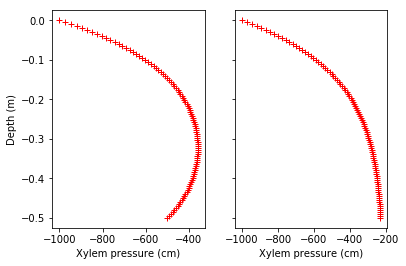

In [5]:
import matplotlib.pyplot as plt

g = 9.81 # gravitational acceleration (m/s^2)   
rho = 1.e3 # density of water (kg/m^3)      
ref = 1.e5 # reference pressure (Pa)

def toPa(ph): # cm pressure head to Pascal (kg/ (m s^2))
    return ref + ph/100. * rho * g

def toHead(pa): # Pascal (kg/ (m s^2)) to cm pressure head
    return (pa-ref) * 100 / rho / g

h1_ = toHead(read1D_vtp_data(path+"singleroot_S1-00001.vtp", False))
h2_ = toHead(read1D_vtp_data(path+"singleroot_S2-00001.vtp", False))
z_ = np.linspace(0,-0.5,len(h1_))

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.plot(h1_,z_, "r+")
ax2.plot(h2_,z_, "r+")
ax1.set_ylabel("Depth (m)")
ax1.set_xlabel("Xylem pressure (cm)")
ax2.set_xlabel("Xylem pressure (cm)")
plt.show()

For comparison, we prepare the analytical solution for Scenario 1 and 2

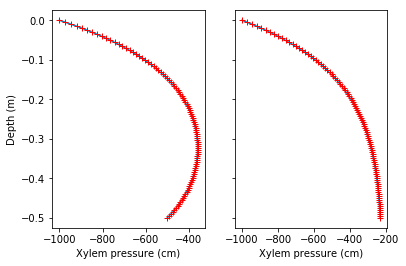

In [14]:
from math import *
# Parameters
L = 0.5                # length of single straight root (m)
a = 2.e-3              # radius (m)
kz = 5.e-13            # axial conductivity (m^5 s / kg) (mal rho ergibt die alten einheiten)
kr = 2.e-9             # radial conductivity per root type (m^2 s / kg) 
p_s = toPa(-200)       # static soil pressure (cm) 
p0 = toPa(-1000)       # dircichlet bc at top
pL = toPa(-500)        # dircichlet bc at bot
# Analytical solution
c = 2*a*pi*kr/kz
p_r = lambda z: toHead( p_s + d[0]*exp(sqrt(c)*z) + d[1]*exp(-sqrt(c)*z) )
za_ = np.linspace(0,-L,100)
# Scenario 1
AA = np.array([[1,1], [exp(-sqrt(c)*L), exp(sqrt(c)*L)] ]) # dirichlet top & bot
bb = np.array([p0-p_s, pL-p_s]) 
d = np.linalg.solve(AA, bb) 
pr1 = list(map(p_r, za_))
# Scenario 2
AA = np.array([[1,1], [sqrt(c)*exp(-sqrt(c)*L), -sqrt(c)*exp(sqrt(c)*L)] ]) # dirichlet top, neumann bot
bb = np.array([p0-p_s, -rho*g]) 
d = np.linalg.solve(AA, bb) 
pr2 = list(map(p_r, za_))
# The final plot
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.plot(pr1,za_)
ax1.plot(h1_,z_, "r+")
ax2.plot(pr2,za_)
ax2.plot(h2_,z_, "r+")
ax1.set_ylabel("Depth (m)")
ax1.set_xlabel("Xylem pressure (cm)")
ax2.set_xlabel("Xylem pressure (cm)")
plt.show()

## Benchmark 2 

We start by creating a DGF file containing the small rootsystem, and attaching all segment dependent data to the segments. 

The root system data of Benchmark 2 is given by

In [11]:
nodes = [ [0.00,0.00,-2.9], [0.00,0.00,-3.00], [-0.00,-0.01,-3.48], [-0.85,0.48,-3.71], [-1.69,0.99,-3.90], [-2.58,1.32,-4.21], [-3.48,1.67,-4.49], [-4.38,2.00,-4.77], [-5.24,2.40,-5.09], [-6.08,2.82,-5.42], [-6.93,3.27,-5.69], [-6.96,3.29,-5.70], [-0.00,0.01,-3.97], [0.20,-0.95,-4.20], [0.43,-1.88,-4.49], [0.65,-2.81,-4.77], [0.84,-3.75,-5.06], [1.04,-4.70,-5.31], [1.27,-5.64,-5.54], [1.43,-6.58,-5.84], [1.48,-6.91,-5.94], [-0.01,0.03,-4.45], [0.75,0.68,-4.48], [1.52,1.32,-4.50], [2.30,1.94,-4.46], [3.07,2.58,-4.41], [3.88,3.16,-4.46], [4.73,3.69,-4.50], [5.34,4.05,-4.53], [-0.03,0.06,-4.97], [-0.73,0.63,-5.40], [-1.46,1.20,-5.79], [-2.15,1.80,-6.18], [-2.76,2.48,-6.59], [-3.16,3.16,-7.21], [-3.63,3.90,-7.64], [-0.06,0.07,-5.42], [0.07,1.04,-5.61], [0.23,2.00,-5.82], [0.46,2.93,-6.11], [0.72,3.85,-6.40], [0.99,4.77,-6.69], [1.06,5.11,-6.78], [-0.10,0.08,-5.96], [0.35,0.90,-6.31], [0.80,1.72,-6.65], [1.23,2.55,-7.01], [1.62,3.41,-7.34], [1.70,3.58,-7.41], [-0.14,0.10,-6.46], [0.05,-0.81,-6.83], [0.29,-1.72,-7.18], [0.43,-2.62,-7.59], [0.50,-3.12,-7.84], [-0.19,0.12,-7.02], [0.32,0.98,-7.03], [0.82,1.84,-6.95], [1.07,2.23,-6.88], [-0.23,0.17,-7.56], [0.68,-0.18,-7.80], [1.12,-0.35,-7.93], [-0.24,0.21,-8.14], [-0.01,0.36,-8.22], [-0.25,0.24,-8.69], [-0.24,0.25,-9.25], [-0.24,0.26,-9.71], [-0.26,0.26,-10.09], [-0.28,0.25,-10.57], [-0.26,0.24,-11.05], [-0.26,0.21,-11.58], [-0.25,0.19,-12.06], [-0.25,0.17,-12.55], [-0.23,0.15,-13.00], [-0.23,0.12,-13.46], [-0.22,0.12,-13.99], [-0.21,0.15,-14.54], [-0.19,0.20,-15.07], [-0.17,0.24,-15.60], [-0.17,0.31,-16.17], [-0.15,0.36,-16.64], [-0.12,0.43,-17.18], [-0.11,0.48,-17.70], [-0.07,0.52,-18.23], [-0.06,0.53,-18.53] ]
seg = [ [0,1], [1,2], [2,12], [12,21], [21,29], [29,36], [36,43], [43,49], [49,54], [54,58], [58,61], [61,63], [63,64], [64,65], [65,66], [66,67], [67,68], [68,69], [69,70], [70,71], [71,72], [72,73], [73,74], [74,75], [75,76], [76,77], [77,78], [78,79], [79,80], [80,81], [81,82], [82,83], [2,3], [3,4], [4,5], [5,6], [6,7], [7,8], [8,9], [9,10], [10,11], [12,13], [13,14], [14,15], [15,16], [16,17], [17,18], [18,19], [19,20], [21,22], [22,23], [23,24], [24,25], [25,26], [26,27], [27,28], [29,30], [30,31], [31,32], [32,33], [33,34], [34,35], [36,37], [37,38], [38,39], [39,40], [40,41], [41,42], [43,44], [44,45], [45,46], [46,47], [47,48], [49,50], [50,51], [51,52], [52,53], [54,55], [55,56], [56,57], [58,59], [59,60], [61,62] ]
age = [ 8,7.76,7.52,7.29,7.03,6.80,6.53,6.28,6.00,5.73,5.43,5.16,4.87,4.64,4.44,4.20,3.95,3.68,3.43,3.17,2.94,2.70,2.42,2.14,1.85,1.57,1.27,1.02,0.73,0.45,0.16,-0.00,2.29,2.02,1.74,1.43,1.11,0.77,0.41,0.01,0.00,2.04,1.77,1.48,1.18,0.85,0.51,0.14,0.00,1.78,1.51,1.22,0.92,0.60,0.26,0.00,1.51,1.24,0.96,0.66,0.34,0.00,1.28,1.01,0.73,0.43,0.12,0.00,0.97,0.69,0.39,0.07,0.00,0.72,0.45,0.17,0.00,0.41,0.14,0.00,0.13,0.00,0.00 ]
types = [ 1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2 ]

a_tap = 0.2 # tap root radius (cm)
a_lateral = 0.1 # lateral root radius (cm)

kz0, kz1 = 0.5e-19, 1.e-18 # m^4 / (Pa s)
kr0, kr1 = 1.7e-13, 0.2e-13 # m / (Pa s)
kz = lambda age: kz0*(age<=3)+kz1*(age>3)
kr = lambda age: kr0*(age<=3)+kr1*(age>3)

We prepare the parameters that we want to pass via the DGF file and store it in the file 'rootsystem.dgf'

In [12]:
a = lambda t: 1.e-2*(a_tap*(t==1)+a_lateral*(t==2)) # cm->m 
a_ = list(map(a, types)) 
kr_ = list(map(kr, age)) # m / (Pa s)
kz_ = list(map(kz, age)) # m^4 / (Pa s)
nodes = np.array(nodes)*1.e-2 # cm->m, and convert from list to numpy array
seg = np.array(seg) # convert from list to numpy array 
    
params = np.vstack((a_,kr_,kz_))
createDGF_1Droots("rootsystem.dgf", nodes, seg, params)

The rest of the parameter stays in the Dumux input file:

```
[Grid]
File = rootsystem.dgf

[Parameter]
SoilP = -200 # cm pressure head
P0 = -1000 # cm pressure head
Scenario = 2 # 1 or 2  

[Problem]
Name = rootsystem # name passed to the output routines
EnableGravity = 1
```